In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
gE = 0.1
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([10, 10])
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (E0 + Ia0 + Is0 + R0)

Tf = 160
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}

# use pyross stochastic to generate traj and save 

# sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
# data=sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf)
# data_array = data['X']
# np.save('sto_traj.npy', data_array)

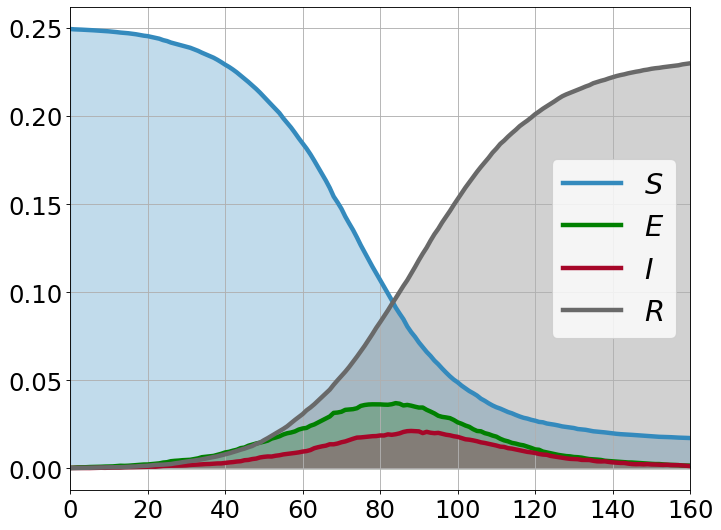

In [8]:
# plot the data and obtain the epidemic curve for one age group 

S  = data['X'][:,0]
E  = data['X'][:,2]
Ia = data['X'][:,4]
Is = data['X'][:,6]
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)


plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R=Ni[0]-S-Ia-Is-E; 
plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)

In [4]:
# load the data and rescale to intensive variables 
x = np.load('sto_traj.npy').astype('float')
x = x/N
steps = 101


# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-3530.220380971277
1.083611249923706


In [5]:
# take a guess 
beta_g = 0.05
gIa_g = 0.2
gIs_g = 0.2
alpha_g = 0.2
gE_g = 0.02 

guess = [alpha_g, beta_g, gIa_g, gIs_g, gE_g]

# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g, 'gE':gE_g, 'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp) 

55901.85114862693


In [6]:
start_time = time.time() 
params, nit = estimator.inference(guess, x, Tf, Nf, contactMatrix, method='L-BFGS-B') # currently only guess four parameters
end_time = time.time()
print(params) # best guess 
print(nit) # number of iterations of the optimization run 
print(end_time - start_time)

[0.21100696 0.0200215  0.14986732 0.14104803 0.10085413]
34
388.0562570095062
